<center>
<h1><b> ZEE RECOMMENDER SYSTEMS </h1>
Project by Atharva Nitin Deshpande (Scaler DSML August 2024 Batch)

## 1. Defining the Problem and Exploratory Data Analysis (EDA)

### 1.1 Definition of Problem

We are asked to create a Recommender System to show personalized movie recommendations based on ratings given by a user and other users similar to them in order to improve user experience.

#### MOVIES FILE DESCRIPTION
================================================================================

Movie information is in the file "movies.dat" and is in the following
format:

MovieID::Title::Genres

- Titles are identical to titles provided by the IMDB (including
year of release)
- Genres are pipe-separated and are selected from the following genres:

	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western

### RATINGS FILE DESCRIPTION
================================================================================

All ratings are contained in the file "ratings.dat" and are in the
following format:

UserID::MovieID::Rating::Timestamp

- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds
- Each user has at least 20 ratings

#### USERS FILE DESCRIPTION
================================================================================

User information is in the file "users.dat" and is in the following
format:

UserID::Gender::Age::Occupation::Zip-code

All demographic information is provided voluntarily by the users and is
not checked for accuracy.  
Only users who have provided some demographic
information are included in this data set.

- Gender is denoted by a "M" for male and "F" for female
- Age is chosen from the following ranges:

	*  1:  "Under 18"
	* 18:  "18-24"
	* 25:  "25-34"
	* 35:  "35-44"
	* 45:  "45-49"
	* 50:  "50-55"
	* 56:  "56+"

- Occupation is chosen from the following choices:

	*  0:  "other" or not specified
	*  1:  "academic/educator"
	*  2:  "artist"
	*  3:  "clerical/admin"
	*  4:  "college/grad student"
	*  5:  "customer service"
	*  6:  "doctor/health care"
	*  7:  "executive/managerial"
	*  8:  "farmer"
	*  9:  "homemaker"
	* 10:  "K-12 student"
	* 11:  "lawyer"
	* 12:  "programmer"
	* 13:  "retired"
	* 14:  "sales/marketing"
	* 15:  "scientist"
	* 16:  "self-employed"
	* 17:  "technician/engineer"
	* 18:  "tradesman/craftsman"
	* 19:  "unemployed"
	* 20:  "writer"

In [1]:
!pip install -r requirements.txt

Let us import the required libraries.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from cmfrec import CMF
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

import warnings
warnings.filterwarnings('ignore')

### 1.2 Exploratory Data Analysis (EDA)

#### 1.2.1 Movies 

In [3]:
movies = pd.read_csv('zee-movies.dat',sep='::',engine='python', encoding='latin1')
movies.head()

,Movie ID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
# Getting the year of release from the title
movies['Year'] = movies['Title'].str.extract(r'\((\d{4})\)').astype(float)
movies.head()

,Movie ID,Title,Genres,Year
0,1,Toy Story (1995),Animation|Children's|Comedy,1995.0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995.0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995.0
3,4,Waiting to Exhale (1995),Comedy|Drama,1995.0
4,5,Father of the Bride Part II (1995),Comedy,1995.0


In [5]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Movie ID  3883 non-null   int64  
 1   Title     3883 non-null   object 
 2   Genres    3883 non-null   object 
 3   Year      3883 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 121.5+ KB


In [6]:
movies.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Movie ID,3883.0,NaN,NaN,NaN,1986.049446,1146.778349,1.0,982.5,2010.0,2980.5,3952.0
Title,3883,3883,Toy Story (1995),1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Genres,3883,301,Drama,843,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,3883.0,NaN,NaN,NaN,1986.066959,16.89569,1919.0,1982.0,1994.0,1997.0,2000.0


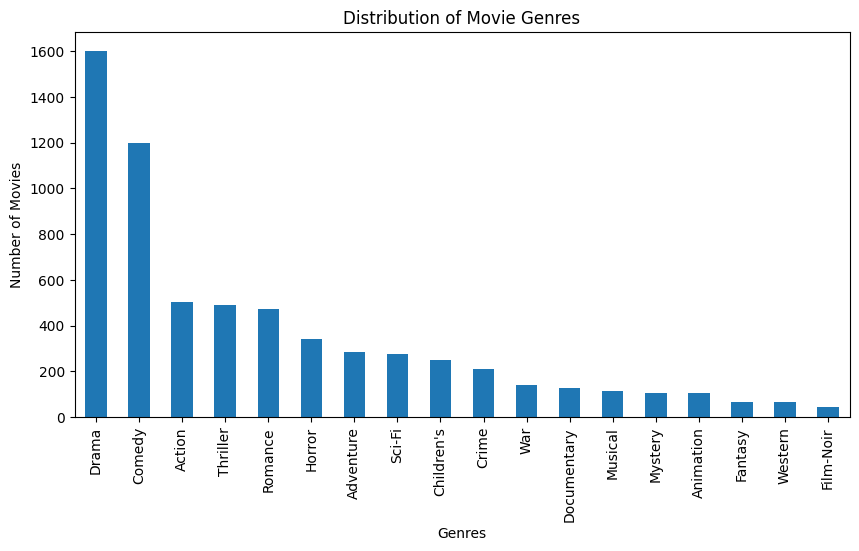

In [7]:
# Analyzing the distribution of movie genres
movies['Genres'].str.split('|').explode().value_counts().plot(kind='bar', figsize=(10,5))
plt.title('Distribution of Movie Genres')
plt.xlabel('Genres')
plt.ylabel('Number of Movies')
plt.show()

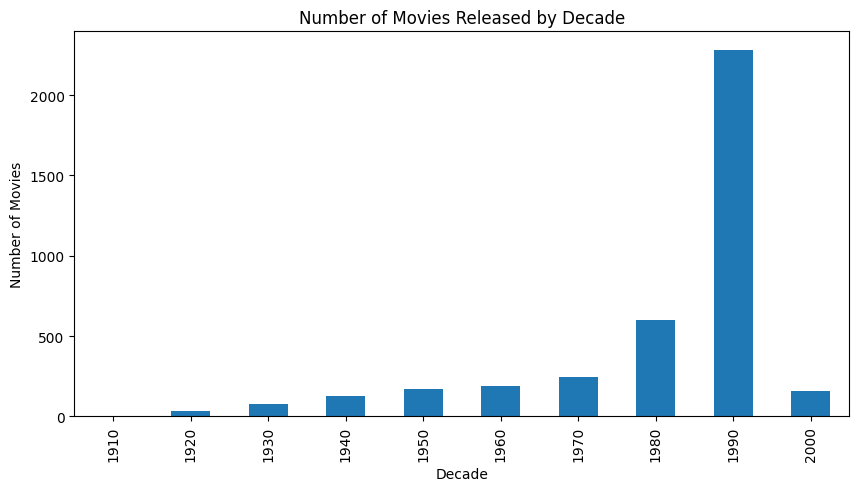

In [8]:
# Analyzing the year of movie releases by decade
movies['Decade'] = ((movies['Year'] // 10) * 10).astype(int)
movies['Decade'].value_counts().sort_index().plot(kind='bar', figsize=(10,5))
plt.title('Number of Movies Released by Decade')
plt.xlabel('Decade')
plt.ylabel('Number of Movies')
plt.show()

#### 1.2.2 Ratings

In [9]:
ratings = pd.read_csv('zee-ratings.dat',sep='::',engine='python', encoding='latin1')
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [10]:
# Converting Timestamp to Datetime
ratings['Timestamp'] = ratings['Timestamp'].apply(lambda x: datetime.fromtimestamp(x))

In [11]:
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,2001-01-01 03:42:40
1,1,661,3,2001-01-01 04:05:09
2,1,914,3,2001-01-01 04:02:48
3,1,3408,4,2001-01-01 03:34:35
4,1,2355,5,2001-01-07 05:08:11


In [12]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   UserID     1000209 non-null  int64         
 1   MovieID    1000209 non-null  int64         
 2   Rating     1000209 non-null  int64         
 3   Timestamp  1000209 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 30.5 MB


In [13]:
ratings.describe(include='all').T

,count,mean,min,25%,50%,75%,max,std
UserID,1000209.0,3024.512348,1.0,1506.0,3070.0,4476.0,6040.0,1728.412695
MovieID,1000209.0,1865.539898,1.0,1030.0,1835.0,2770.0,3952.0,1096.040689
Rating,1000209.0,3.581564,1.0,3.0,4.0,4.0,5.0,1.117102
Timestamp,1000209,2000-10-23 01:11:35.404665344,2000-04-26 04:35:32,2000-08-03 17:07:17,2000-11-01 00:16:46,2000-11-26 12:12:19,2003-02-28 23:19:50,NaN


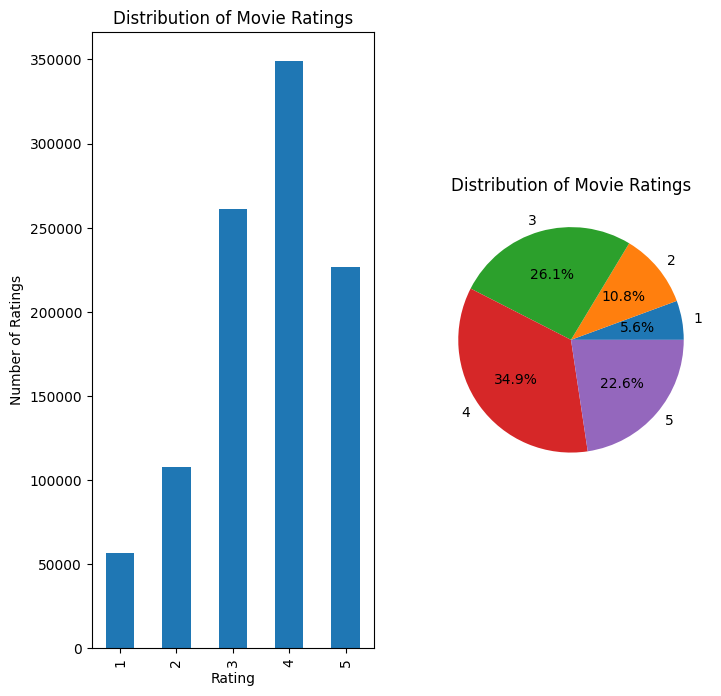

In [14]:
# Analyzing the ratings distribution using bar and pie charts
plt.subplot(1, 2, 1)
ratings['Rating'].value_counts().sort_index().plot(kind='bar', figsize=(10,5))
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.subplot(1, 2, 2)
ratings['Rating'].value_counts().sort_index().plot(kind='pie', autopct='%1.1f%%', figsize=(8,8))
plt.title('Distribution of Movie Ratings')  
plt.ylabel('')
plt.show()

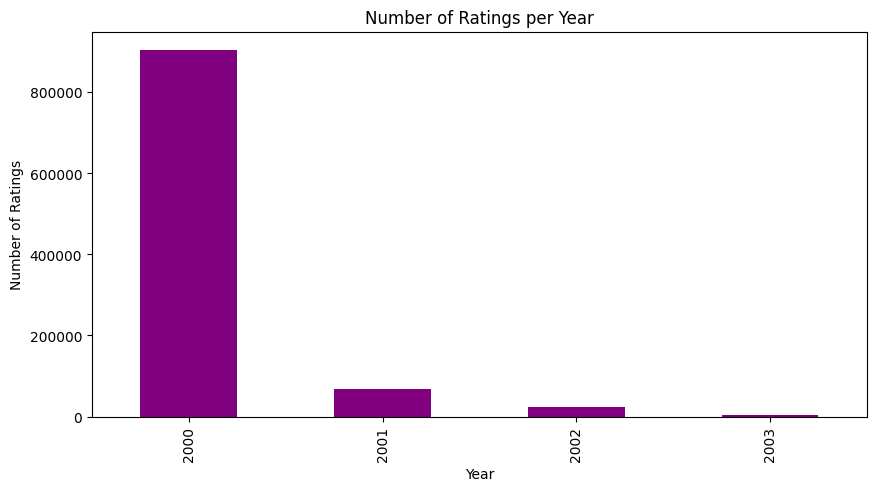

In [15]:
# Analyzing the Timestamp distribution
ratings['Timestamp'].dt.year.value_counts().sort_index().plot(kind='bar', figsize=(10,5), color='purple')
plt.title('Number of Ratings per Year')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')
plt.show()

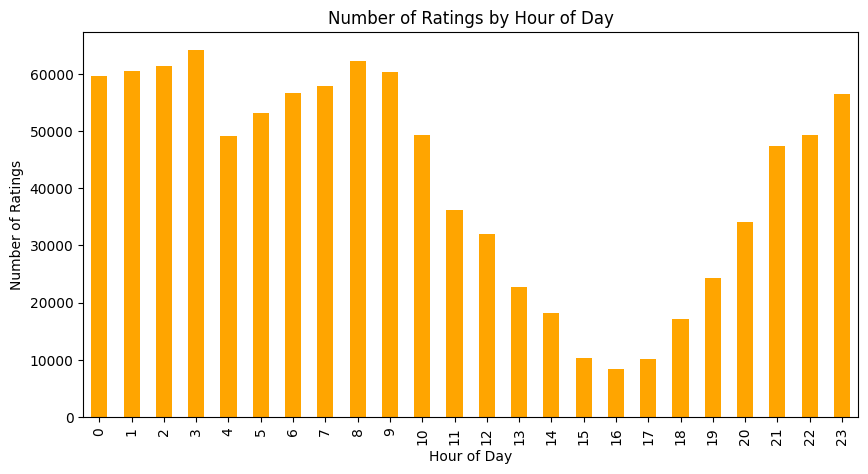

In [16]:
# Analyzing the time of ratings
ratings['Timestamp'].dt.hour.value_counts().sort_index().plot(kind='bar', figsize=(10,5), color='orange')
plt.title('Number of Ratings by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Ratings')
plt.show()

In [17]:
movies_ratings = pd.merge(movies, ratings, left_on='Movie ID', right_on='MovieID', how='inner')
movies_ratings.head()

,Movie ID,Title,Genres,Year,Decade,UserID,MovieID,Rating,Timestamp
0,1,Toy Story (1995),Animation|Children's|Comedy,1995.0,1990,1,1,5,2001-01-07 05:07:48
1,1,Toy Story (1995),Animation|Children's|Comedy,1995.0,1990,6,1,4,2000-12-31 10:00:08
2,1,Toy Story (1995),Animation|Children's|Comedy,1995.0,1990,8,1,4,2000-12-31 09:01:36
3,1,Toy Story (1995),Animation|Children's|Comedy,1995.0,1990,9,1,5,2000-12-31 06:55:52
4,1,Toy Story (1995),Animation|Children's|Comedy,1995.0,1990,10,1,5,2000-12-31 07:04:34


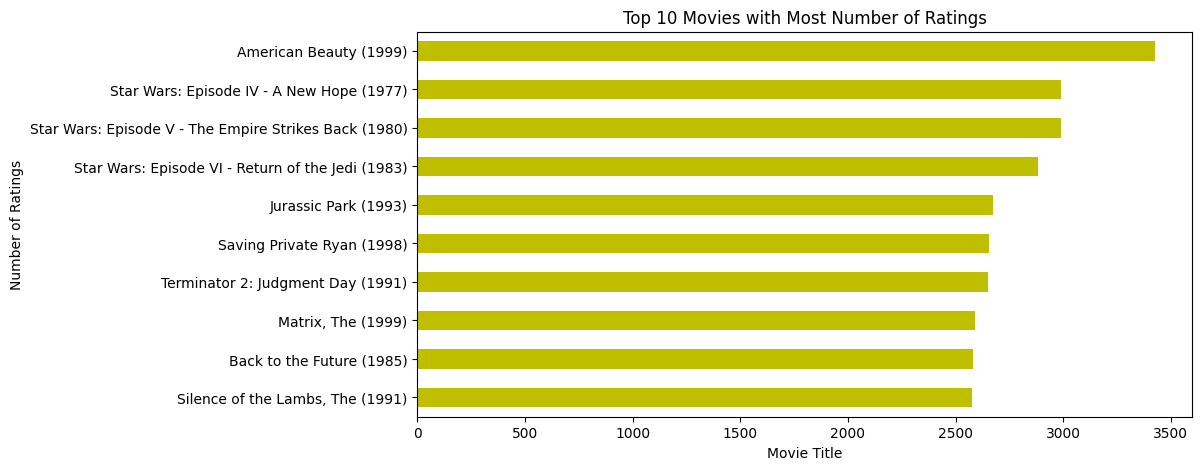

In [18]:
# Getting top 10 titles with most number of ratings
top_10_rated_movies = movies_ratings['Title'].value_counts().head(10).sort_values(ascending=True)
top_10_rated_movies.plot(kind='barh', figsize=(10,5), color='y')
plt.title('Top 10 Movies with Most Number of Ratings')
plt.xlabel('Movie Title')
plt.ylabel('Number of Ratings')
plt.show()

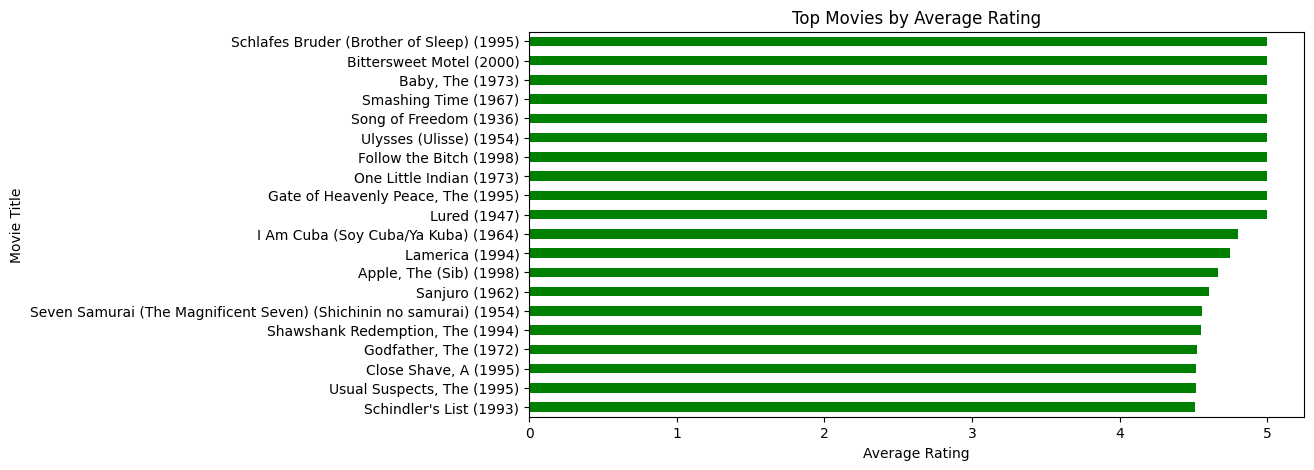

In [19]:
# Getting top 10 movies by average rating
top_movies = movies_ratings.groupby('Title')['Rating'].mean().sort_values(ascending=True).tail(20)
top_movies.plot(kind='barh', figsize=(10,5), color='g')
plt.title('Top Movies by Average Rating')    
plt.xlabel('Average Rating')
plt.ylabel('Movie Title')
plt.show()

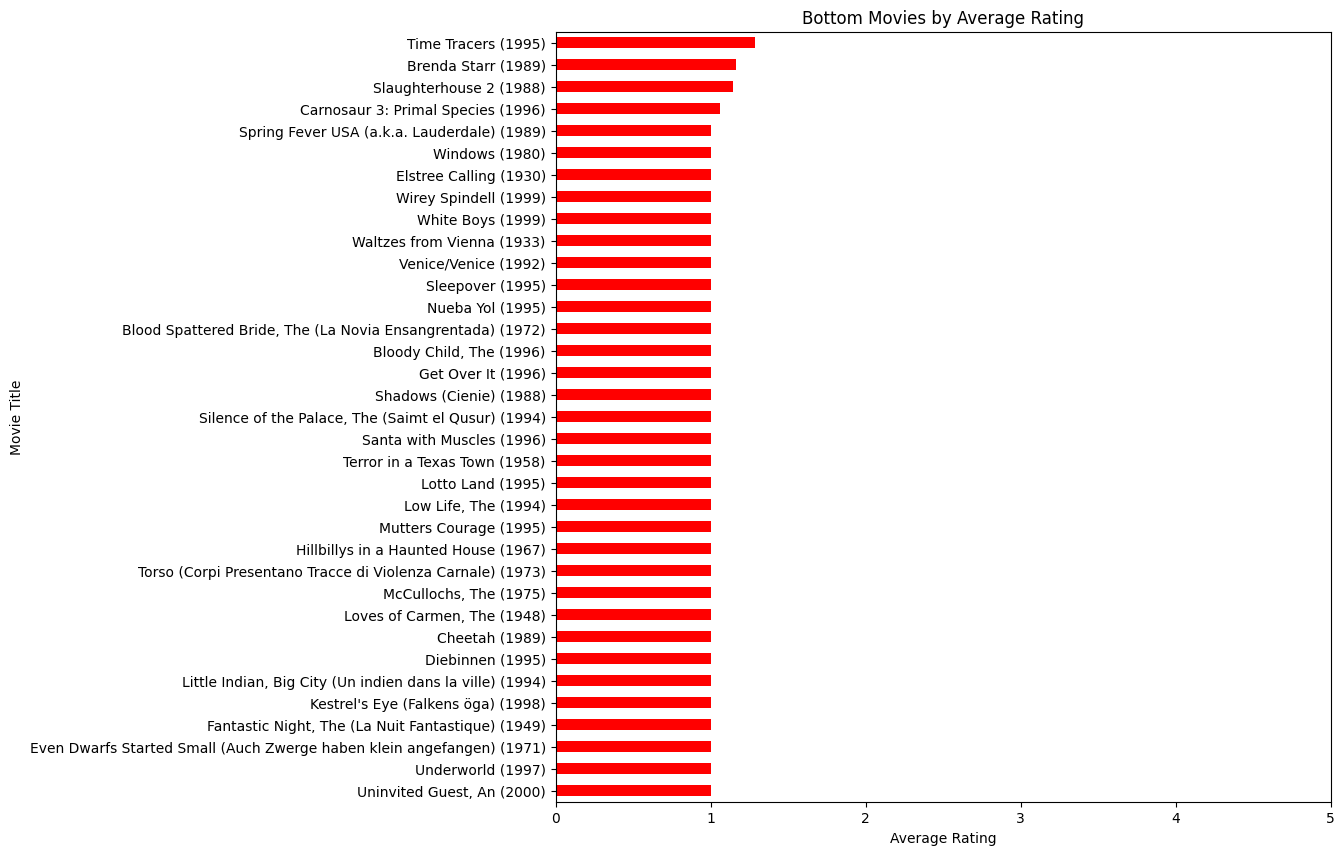

In [20]:
# Getting bottom 10 movies by average rating
bottom_movies = movies_ratings.groupby('Title')['Rating'].mean().sort_values(ascending=True).head(35)
bottom_movies.plot(kind='barh', figsize=(10,10), color='r')
plt.title('Bottom Movies by Average Rating')    
plt.xlabel('Average Rating')
plt.ylabel('Movie Title')
plt.xlim(0,5)
plt.show()

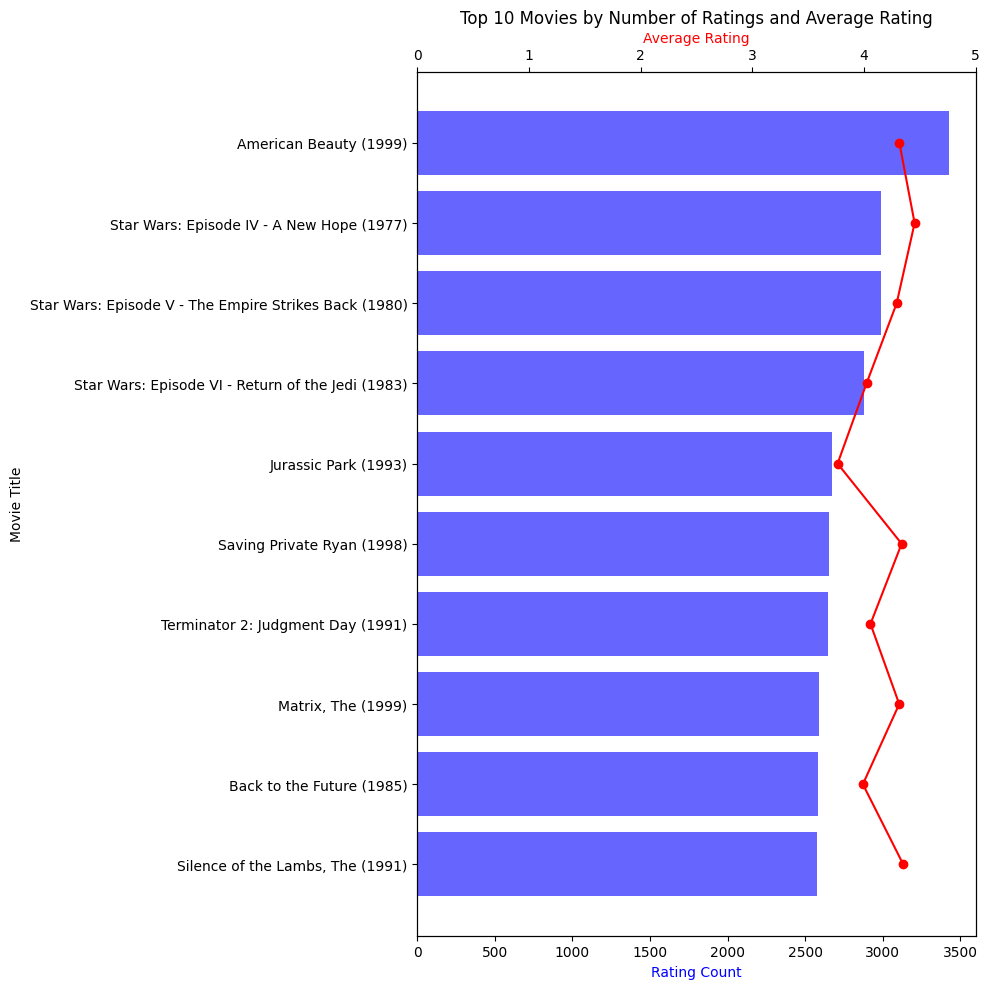

In [21]:
# Getting top 10 movies sorted first by number of ratings then by average rating
top_10_movies = movies_ratings.groupby('Title').agg({'Rating': ['count', 'mean']})
top_10_movies.columns = ['Rating Count', 'Average Rating']
top_10_movies = top_10_movies.sort_values(by='Rating Count', ascending=True).tail(10)
fig, ax1 = plt.subplots(figsize=(10,10))
ax1.barh(top_10_movies.index, top_10_movies['Rating Count'], color='b', alpha=0.6, label='Rating Count')
ax1.set_ylabel('Movie Title')
ax1.set_yticks(range(len(top_10_movies.index)))
ax1.set_yticklabels(top_10_movies.index)
ax1.set_xlabel('Rating Count', color='b')
ax2 = ax1.twiny()
ax2.plot(top_10_movies['Average Rating'], top_10_movies.index, color='r', marker='o', label='Average Rating')
ax2.set_xlabel('Average Rating', color='r')
ax2.set_xlim(0,5)
plt.title('Top 10 Movies by Number of Ratings and Average Rating')
fig.tight_layout()
plt.show()

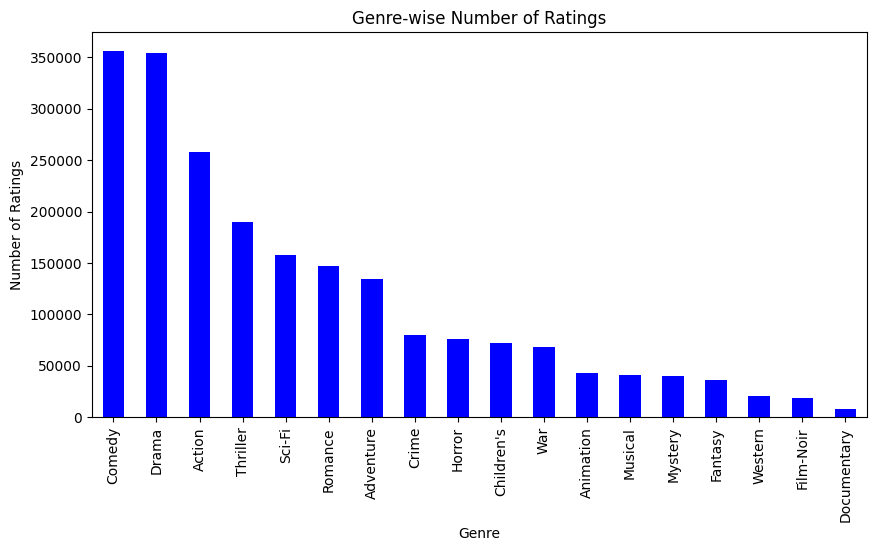

In [22]:
# Getting genre-wise number of ratings plot
genre_ratings = movies_ratings.copy()   
genre_ratings = genre_ratings.assign(Genre=genre_ratings['Genres'].str.split('|')).explode('Genre')
genre_counts = genre_ratings['Genre'].value_counts().sort_values(ascending=False)
genre_counts.plot(kind='bar', figsize=(10,5), color='b', legend=False)
plt.title('Genre-wise Number of Ratings')
plt.xlabel('Genre')
plt.ylabel('Number of Ratings')
plt.show()

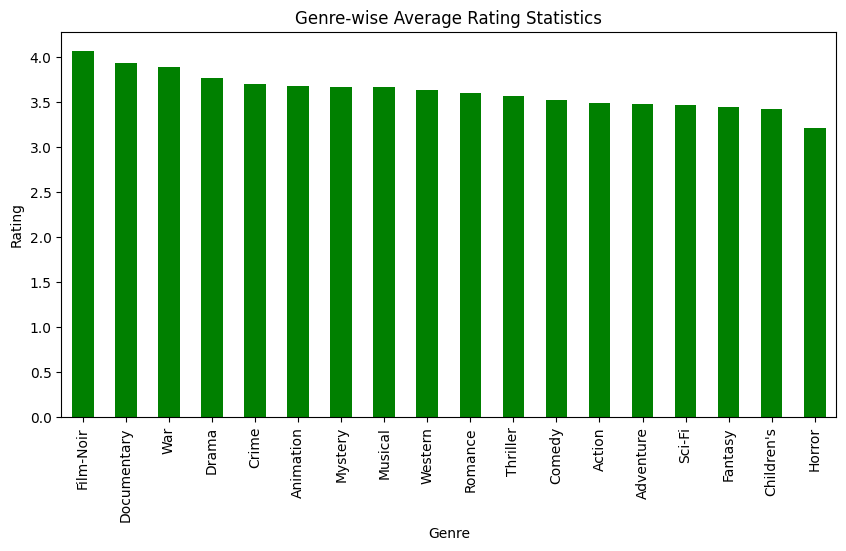

In [23]:
# Getting genre wise average rating plot, sorted by average rating
genre_ratings = movies_ratings.copy()
genre_ratings = genre_ratings.assign(Genre=genre_ratings['Genres'].str.split('|')).explode('Genre')
genre_stats = genre_ratings.groupby('Genre')['Rating'].agg(['mean']).sort_values(by='mean', ascending=False)
genre_stats.plot(kind='bar', figsize=(10,5), color='g', legend=False)
plt.title('Genre-wise Average Rating Statistics')
plt.xlabel('Genre')
plt.ylabel('Rating')
plt.show()

#### 1.2.3 Users

In [24]:
users = pd.read_csv('zee-users.dat',sep='::',engine='python', encoding='latin1')
users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [25]:
# Encoding Occupation column with actual occupation names
occupation_mapping = {
    0: "other or not specified",
    1: "academic/educator",
    2: "artist",
    3: "clerical/admin",
    4: "college/grad student",
    5: "customer service",
    6: "doctor/health care",
    7: "executive/managerial",
    8: "farmer",
    9: "homemaker",
    10: "K-12 student",
    11: "lawyer",
    12: "programmer",
    13: "retired",
    14: "sales/marketing",
    15: "scientist",
    16: "self-employed",
    17: "technician/engineer",
    18: "tradesman/craftsman",
    19: "unemployed",
    20: "writer"
}
# use .loc for mapping
users['Occupation'] = users['Occupation'].astype(object)
users.loc[:, 'Occupation'] = users['Occupation'].map(occupation_mapping)
users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,K-12 student,48067
1,2,M,56,self-employed,70072
2,3,M,25,scientist,55117
3,4,M,45,executive/managerial,02460
4,5,M,25,writer,55455


In [26]:
age_mapping = {
    1: "Under 18",
    18: "18-24",
    25: "25-34",
    35: "35-44",
    45: "45-49",
    50: "50-55",
    56: "56+"
}
users['Age'] = users['Age'].astype(object)
users['Age'] = users['Age'].map(age_mapping)

users['Age'] = pd.Categorical(users['Age'], categories=[
    "Under 18", "18-24", "25-34", "35-44", "45-49", "50-55", "56+"], ordered=True)
users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,Under 18,K-12 student,48067
1,2,M,56+,self-employed,70072
2,3,M,25-34,scientist,55117
3,4,M,45-49,executive/managerial,02460
4,5,M,25-34,writer,55455


In [27]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   UserID      6040 non-null   int64   
 1   Gender      6040 non-null   object  
 2   Age         6040 non-null   category
 3   Occupation  6040 non-null   object  
 4   Zip-code    6040 non-null   object  
dtypes: category(1), int64(1), object(3)
memory usage: 195.1+ KB


In [28]:
users.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
UserID,6040.0,NaN,NaN,NaN,3020.5,1743.742145,1.0,1510.75,3020.5,4530.25,6040.0
Gender,6040,2,M,4331,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,6040,7,25-34,2096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,6040,21,college/grad student,759,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zip-code,6040,3439,48104,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN


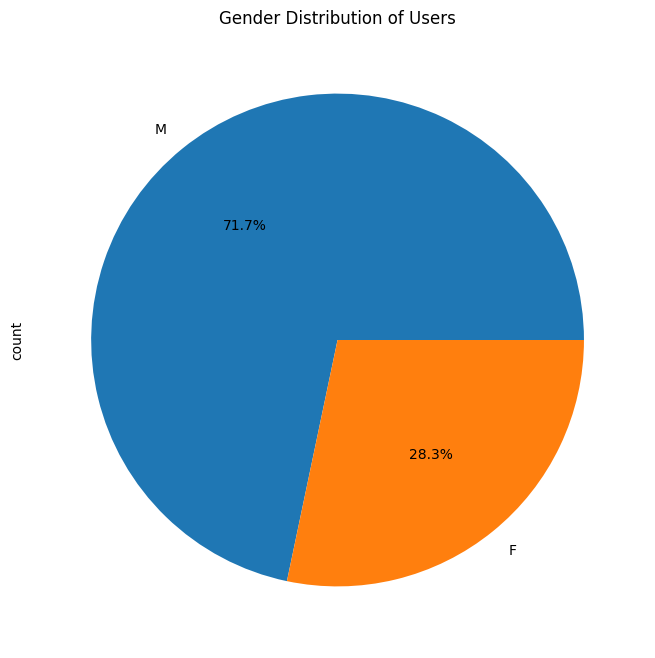

In [29]:
# Gender distribution of users (pie chart)
users['Gender'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(8,8))
plt.title('Gender Distribution of Users')  
plt.show()

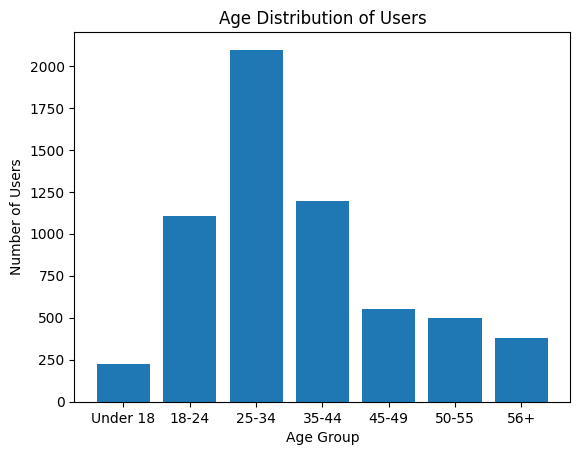

In [30]:
# Age distribution of users (age is now categorical after mapping)
plt.bar(users['Age'].value_counts().sort_index().index, users['Age'].value_counts().sort_index().values)
plt.title('Age Distribution of Users')  
plt.xlabel('Age Group')
plt.ylabel('Number of Users')
plt.show()

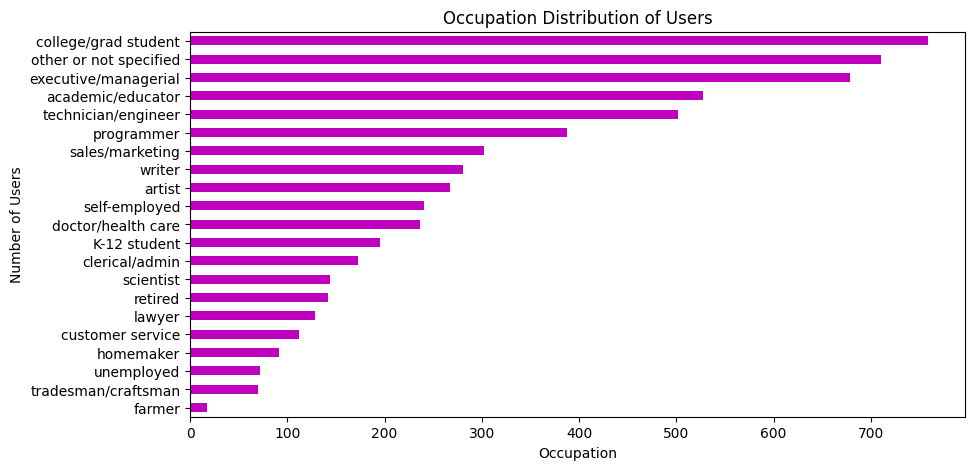

In [31]:
# Occupation distribution of users
users['Occupation'].value_counts().sort_values(ascending=True).plot(kind='barh', figsize=(10,5), color='m')
plt.title('Occupation Distribution of Users')   
plt.xlabel('Occupation')
plt.ylabel('Number of Users')
plt.show()

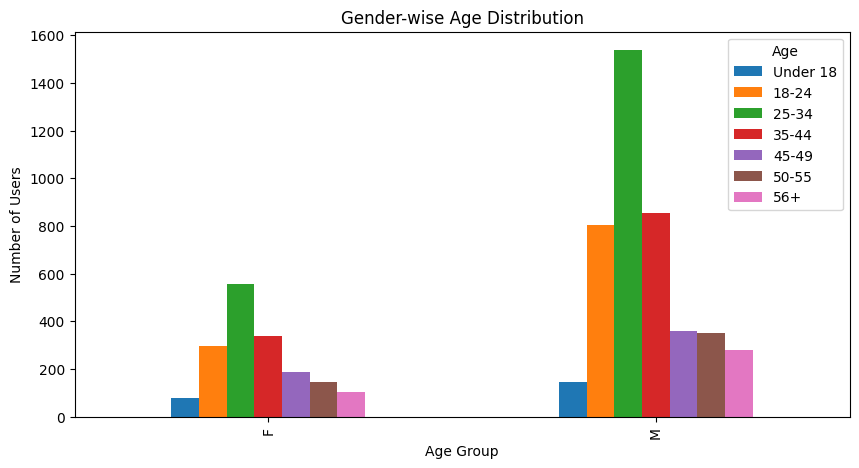

In [32]:
# Gender-wise age distribution
gender_age_dist = users.groupby(['Gender', 'Age'], observed=True).size().unstack().fillna(0)
gender_age_dist.plot(kind='bar', figsize=(10,5))
plt.title('Gender-wise Age Distribution')
plt.xlabel('Age Group')
plt.ylabel('Number of Users')
plt.show()

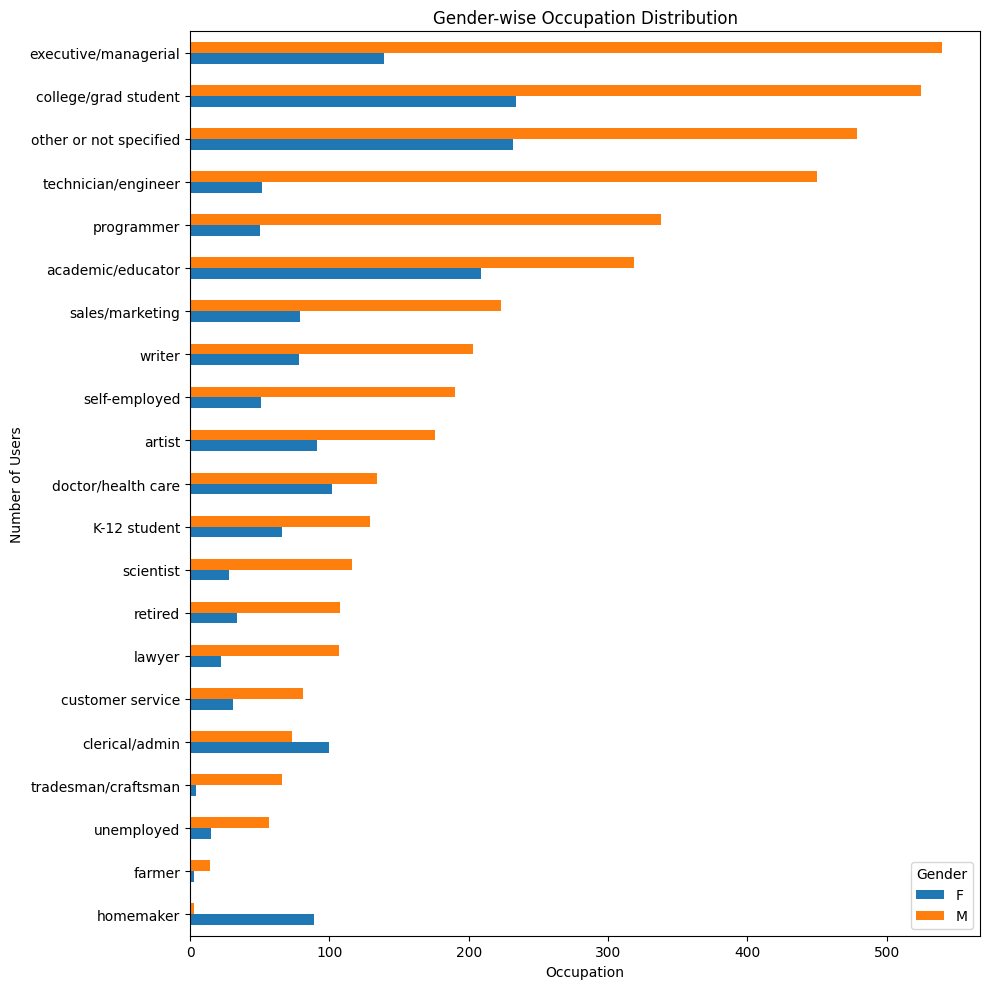

In [33]:
# Gender-wise occupation distribution
gender_occupation_dist = users.groupby(['Occupation', 'Gender'], observed=True).size().unstack().fillna(0).sort_values(by='M')
gender_occupation_dist.plot(kind='barh', figsize=(10,10))
plt.title('Gender-wise Occupation Distribution')
plt.xlabel('Occupation')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()

In [34]:
# merging everything together
df = pd.merge(movies_ratings, users, left_on='UserID', right_on='UserID', how='inner')
# Dropping unnecessary columns
df = df.drop(columns=['MovieID'])
df.head()

,Movie ID,Title,Genres,Year,Decade,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code
0,1,Toy Story (1995),Animation|Children's|Comedy,1995.0,1990,1,5,2001-01-07 05:07:48,F,Under 18,K-12 student,48067
1,1,Toy Story (1995),Animation|Children's|Comedy,1995.0,1990,6,4,2000-12-31 10:00:08,F,50-55,homemaker,55117
2,1,Toy Story (1995),Animation|Children's|Comedy,1995.0,1990,8,4,2000-12-31 09:01:36,M,25-34,programmer,11413
3,1,Toy Story (1995),Animation|Children's|Comedy,1995.0,1990,9,5,2000-12-31 06:55:52,M,25-34,technician/engineer,61614
4,1,Toy Story (1995),Animation|Children's|Comedy,1995.0,1990,10,5,2000-12-31 07:04:34,F,35-44,academic/educator,95370


## 2. Data Proprocessing



### 2.1 Data Cleaning and Formatting

In [59]:
df.duplicated().sum()

np.int64(0)

### 2.2 Data Transformation


In [35]:
df.columns

Index(['Movie ID', 'Title', 'Genres', 'Year', 'Decade', 'UserID', 'Rating',
       'Timestamp', 'Gender', 'Age', 'Occupation', 'Zip-code'],
      dtype='object')

In [36]:
matrix = pd.pivot_table(df, index='UserID', columns='Title', values='Rating', aggfunc='mean', fill_value=0)
matrix

Title,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),...,"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Young and Innocent (1937),Your Friends and Neighbors (1998),Zachariah (1971),"Zed & Two Noughts, A (1985)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997),eXistenZ (1999)
UserID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0.0,3.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
6037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2.3 Analyzing Sparsity

In [60]:
# sparsity

sparsity = 1.0 - (np.count_nonzero(matrix.values) / float(matrix.size))
print(f"Sparsity of the user-item matrix: {sparsity:.4f}")

Sparsity of the user-item matrix: 0.9553



## 3. Model Building



### 3.1 Collaborative Filtering with Pearson Correlation


In [58]:
# For a given movie, calculate the Pearson Correlation with other movies to find the most similar ones.
def recommend_movies_by_pearson_corr(df, movie_title, top_n=10):
    for col in df.columns:
        if movie_title in col:
            movie_title = col
            break
    movie_rating = df[movie_title]
    similar_movies = df.corrwith(movie_rating)
    sim_df = pd.DataFrame(similar_movies, columns=['Pearson Correlation'])
    sim_df.sort_values(by='Pearson Correlation', ascending=False, inplace=True)
    print(f"Top {top_n} movies similar to '{movie_title}':")
    return sim_df.iloc[1:,:].head(top_n)

recommend_movies_by_pearson_corr(matrix, 'Liar Liar', 3)

Top 3 movies similar to 'Liar Liar (1997)':


,Pearson Correlation
Title,
Mrs. Doubtfire (1993),0.499927
Dumb & Dumber (1994),0.459601
Ace Ventura: Pet Detective (1994),0.458654



### 3.2 Collaborative Filtering with Cosine Similarity


In [39]:
item_sim = cosine_similarity(matrix.T)
item_sim  = pd.DataFrame(item_sim, index=matrix.columns, columns=matrix.columns)
item_sim.head()

Title,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),...,"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Young and Innocent (1937),Your Friends and Neighbors (1998),Zachariah (1971),"Zed & Two Noughts, A (1985)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997),eXistenZ (1999)
Title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck (1971)",1.000000,0.072357,0.037011,0.079291,0.060838,0.00000,0.058619,0.189965,0.172254,0.094785,...,0.038725,0.076474,0.000000,0.044074,0.0,0.045280,0.039395,0.000000,0.120242,0.027003
'Night Mother (1986),0.072357,1.000000,0.115290,0.115545,0.159526,0.00000,0.076798,0.147437,0.095922,0.111413,...,0.053010,0.087828,0.063758,0.135962,0.0,0.091150,0.074787,0.000000,0.000000,0.077807
'Til There Was You (1997),0.037011,0.115290,1.000000,0.098756,0.066301,0.08025,0.127895,0.112654,0.125670,0.079115,...,0.029200,0.062893,0.000000,0.079187,0.0,0.022594,0.079261,0.000000,0.047526,0.063284
"'burbs, The (1989)",0.079291,0.115545,0.098756,1.000000,0.143620,0.00000,0.192191,0.246927,0.175885,0.170719,...,0.113386,0.207897,0.019962,0.138064,0.0,0.055704,0.161174,0.000000,0.033567,0.110525
...And Justice for All (1979),0.060838,0.159526,0.066301,0.143620,1.000000,0.00000,0.075093,0.194154,0.116379,0.205486,...,0.089998,0.153006,0.067009,0.109029,0.0,0.086080,0.110867,0.074317,0.000000,0.111040


In [40]:
user_sim = cosine_similarity(matrix)
user_sim = pd.DataFrame(user_sim, index=matrix.index, columns=matrix.index)
user_sim.head()

UserID,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.096382,0.120610,0.132455,0.090158,0.179222,0.059678,0.138241,0.226148,0.255288,...,0.170588,0.082006,0.069807,0.033663,0.114877,0.186329,0.135979,0.000000,0.174604,0.133590
2,0.096382,1.000000,0.151479,0.171176,0.114394,0.100865,0.305787,0.203337,0.190198,0.226861,...,0.112503,0.091222,0.268565,0.014286,0.183384,0.228241,0.206274,0.066118,0.066457,0.218276
3,0.120610,0.151479,1.000000,0.151227,0.062907,0.074603,0.138332,0.077656,0.126457,0.213655,...,0.092960,0.125864,0.161507,0.000000,0.097308,0.143264,0.107744,0.120234,0.094675,0.133144
4,0.132455,0.171176,0.151227,1.000000,0.045094,0.013529,0.130339,0.100856,0.093651,0.120738,...,0.163629,0.093041,0.382803,0.000000,0.082097,0.170583,0.127464,0.062907,0.064634,0.137968
5,0.090158,0.114394,0.062907,0.045094,1.000000,0.047449,0.126257,0.220817,0.261330,0.117052,...,0.100652,0.035732,0.061806,0.054151,0.179083,0.293365,0.172686,0.020459,0.027689,0.241437


In [41]:
csr_matrix = sparse.csr_matrix(matrix.T.values)
csr_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1000209 stored elements and shape (3706, 6040)>

In [42]:
def recommend_movies_by_knn(df, movie_title, top_n=10):
    for col in df.columns:
        if movie_title in col:
            movie_title = col
            break
    knn = NearestNeighbors(n_neighbors=top_n+1, 
                           metric='cosine', 
                           n_jobs=-1)
    knn.fit(csr_matrix)
    distances, indices = knn.kneighbors(
        df[movie_title].values.reshape(1,-1), 
        n_neighbors=top_n+1
        )
    for i in range(0, len(distances.flatten())):
        if i == 0:
            print('Recommendations for the movie: {0}\n'.format(movie_title))
        else:
            print(f'{i}: {df.columns[indices.flatten()[i]]}, with distance of {round(distances.flatten()[i], 3)}')

recommend_movies_by_knn(matrix, 'Liar Liar', 10)

Recommendations for the movie: Liar Liar (1997)

1: Mrs. Doubtfire (1993), with distance of 0.443
2: Ace Ventura: Pet Detective (1994), with distance of 0.483
3: Dumb & Dumber (1994), with distance of 0.487
4: Home Alone (1990), with distance of 0.489
5: Wayne's World (1992), with distance of 0.501
6: Wedding Singer, The (1998), with distance of 0.503
7: Austin Powers: International Man of Mystery (1997), with distance of 0.511
8: There's Something About Mary (1998), with distance of 0.517
9: League of Their Own, A (1992), with distance of 0.518
10: Mask, The (1994), with distance of 0.531



### 3.3 Matrix Factorization


<!-- Matrix Factorization in Recommender Systems -->
<ul>
  <li><strong>Concept:</strong> Decomposes a large user–item rating matrix into the product of two lower-dimensional matrices representing user and item latent factors.</li>
  <li><strong>Goal:</strong> Predict missing ratings by learning hidden patterns linking users and items.</li>
  <li><strong>Mathematical Form:</strong> 
    <p>Given rating matrix R (m×n), approximate as R ≈ P × Q<sup>T</sup>,</p>
    <p>where P is (m×k) user-feature matrix and Q is (n×k) item-feature matrix, and k ≪ m,n.</p>
  </li>
  <li><strong>Optimization Objective:</strong> 
    <p>Minimize the error between observed ratings and predictions:</p>
    <p>min Σ<sub>(u,i)∈K</sub>(R<sub>ui</sub> − P<sub>u</sub>·Q<sub>i</sub><sup>T</sup>)² + λ(||P||² + ||Q||²)</p>
    <p>where λ controls regularization to prevent overfitting.</p>
  </li>
  <li><strong>Algorithms Used:</strong> 
    <ul>
      <li>Stochastic Gradient Descent (SGD)</li>
      <li>Alternating Least Squares (ALS)</li>
    </ul>
  </li>
  <li><strong>Variants:</strong> 
    <ul>
      <li><strong>Bias-aware MF:</strong> Adds user and item bias terms.</li>
      <li><strong>SVD++:</strong> Incorporates implicit feedback.</li>
      <li><strong>Non-negative MF:</strong> Forces latent features to be non-negative for interpretability.</li>
    </ul>
  </li>
  <li><strong>Advantages:</strong> 
    <ul>
      <li>Captures complex user–item relationships in fewer dimensions.</li>
      <li>Scales well with large sparse datasets.</li>
      <li>Supports personalization and latent pattern discovery.</li>
    </ul>
  </li>
  <li><strong>Limitations:</strong> 
    <ul>
      <li>Cold-start problem for new users or items.</li>
      <li>Assumes linear interactions between latent factors.</li>
      <li>Needs sufficient data for stable factor estimation.</li>
    </ul>
  </li>
  <li><strong>Use Cases:</strong> 
    <ul>
      <li>Movie, product, and content recommendations.</li>
      <li>Personalized ranking and rating prediction tasks.</li>
    </ul>
  </li>
</ul>

We will use `cmfrec` library for Collective Matrix Factorization (CMF).


### 3.4 Model Evaluation and Tuning


In [43]:
df1 = df[['UserID', 'Movie ID', 'Rating']].copy()
df1.columns = ['UserId', 'ItemId', 'Rating']
df1.head()

,UserId,ItemId,Rating
0,1,1,5
1,6,1,4
2,8,1,4
3,9,1,5
4,10,1,5


In [44]:
df1['UserId'] = df1['UserId'].astype('category').cat.codes
df1['ItemId'] = df1['ItemId'].astype('category').cat.codes
df1.head()

,UserId,ItemId,Rating
0,0,0,5
1,5,0,4
2,7,0,4
3,8,0,5
4,9,0,5


In [45]:
genres_decoded = pd.DataFrame(columns=movies['Genres'].str.split('|').explode().unique())

for i, row in movies.iterrows():
    genres = row['Genres'].split('|')
    for genre in genres:
        genres_decoded.at[i, genre] = 1
    for genre in genres_decoded.columns:
        if genre not in genres:
            genres_decoded.at[i, genre] = 0

decade_encoded = pd.get_dummies(movies["Decade"].astype(str), prefix="Decade").astype(int)

movie_features = pd.concat([genres_decoded, decade_encoded], axis=1)

movie_features.index = movies['Movie ID'].astype('category').cat.codes
movie_features['ItemId'] = movie_features.index
movie_features.head()

,Animation,Children's,Comedy,Adventure,Fantasy,Romance,Drama,Action,Crime,Thriller,...,Decade_1920,Decade_1930,Decade_1940,Decade_1950,Decade_1960,Decade_1970,Decade_1980,Decade_1990,Decade_2000,ItemId
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,2
3,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,3
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,4


In [46]:
users_age_encoded = pd.get_dummies(users["Age"].astype(str), prefix="Age").astype(int)
users_age_encoded.index = users['UserID'].astype('category').cat.codes

users_occupation_encoded = pd.get_dummies(users["Occupation"], prefix="Occupation").astype(int) 
users_occupation_encoded.index = users['UserID'].astype('category').cat.codes

users_gender_encoded = pd.get_dummies(users["Gender"], prefix="Gender").astype(int)
users_gender_encoded.index = users['UserID'].astype('category').cat.codes

user_features = pd.concat([users_age_encoded, users_occupation_encoded, users_gender_encoded], axis=1)
user_features.index = users['UserID'].astype('category').cat.codes

user_features['UserId'] = user_features.index
user_features.head()

,Age_18-24,Age_25-34,Age_35-44,Age_45-49,Age_50-55,Age_56+,Age_Under 18,Occupation_K-12 student,Occupation_academic/educator,Occupation_artist,...,Occupation_sales/marketing,Occupation_scientist,Occupation_self-employed,Occupation_technician/engineer,Occupation_tradesman/craftsman,Occupation_unemployed,Occupation_writer,Gender_F,Gender_M,UserId
0,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
2,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,2
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,4


In [47]:
train_df, test_df = train_test_split(df1, test_size=0.3, random_state=42)

param_grid = {
    "k": [4, 8, 16, 32],
    "lambda_": [0.01, 0.1, 1, 10, 100],
    "method": ['als'],
    "user_bias": [True],
    "item_bias": [True],
    "use_cg": [True, False],
    "scale_lam": [True]
}

grid = ParameterGrid(param_grid)
best_rmse = float("inf")
best_params = None

In [48]:
results = []
for params in tqdm(grid, desc="Hyperparameter Tuning"):
    model = CMF(**params, niter=50)
    model.fit(X=train_df, 
              U=user_features, 
              I=movie_features)
    train_pred = model.predict(train_df['UserId'], train_df['ItemId'])
    test_pred = model.predict(test_df['UserId'], test_df['ItemId'])

    train_rmse = root_mean_squared_error(train_df['Rating'], train_pred)
    test_rmse = root_mean_squared_error(test_df['Rating'], test_pred)

    train_mape = mean_absolute_percentage_error(train_df['Rating'], train_pred)
    test_mape = mean_absolute_percentage_error(test_df['Rating'], test_pred)

    rmse_diff = abs(train_rmse - test_rmse)
    mape_diff = abs(train_mape - test_mape)

    results.append({
        'params': params,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mape': train_mape,
        'test_mape': test_mape,
        'rmse_diff': rmse_diff,
        'mape_diff': mape_diff
    })

res_df = pd.DataFrame(results)
res_df = res_df.sort_values(by=['test_rmse']).reset_index(drop=True)

Hyperparameter Tuning:   0%|          | 0/40 [00:00<?, ?it/s]

In [49]:
res_df

,params,train_rmse,test_rmse,train_mape,test_mape,rmse_diff,mape_diff
0,"{'item_bias': True, 'k': 32, 'lambda_': 0.1, '...",0.818183,0.869115,0.253690,0.271318,0.050932,0.017628
1,"{'item_bias': True, 'k': 32, 'lambda_': 0.1, '...",0.818350,0.869152,0.253739,0.271333,0.050801,0.017594
2,"{'item_bias': True, 'k': 16, 'lambda_': 0.1, '...",0.822102,0.869251,0.254896,0.271283,0.047149,0.016386
3,"{'item_bias': True, 'k': 16, 'lambda_': 0.1, '...",0.822186,0.869302,0.254919,0.271303,0.047116,0.016384
4,"{'item_bias': True, 'k': 8, 'lambda_': 0.1, 'm...",0.831152,0.870472,0.257743,0.271517,0.039320,0.013774
5,"{'item_bias': True, 'k': 8, 'lambda_': 0.1, 'm...",0.831231,0.870533,0.257764,0.271536,0.039302,0.013772
6,"{'item_bias': True, 'k': 4, 'lambda_': 0.01, '...",0.800404,0.873474,0.238043,0.261271,0.073070,0.023229
7,"{'item_bias': True, 'k': 4, 'lambda_': 0.01, '...",0.800439,0.873483,0.238037,0.261287,0.073044,0.023250
8,"{'item_bias': True, 'k': 4, 'lambda_': 0.1, 'm...",0.844672,0.875330,0.261973,0.273007,0.030659,0.011034
9,"{'item_bias': True, 'k': 4, 'lambda_': 0.1, 'm...",0.844668,0.875331,0.261970,0.273006,0.030662,0.011035


In [50]:
best_params = res_df.head(1)['params'].values[0]
best_params

{'item_bias': True,
 'k': 32,
 'lambda_': 0.1,
 'method': 'als',
 'scale_lam': True,
 'use_cg': False,
 'user_bias': True}

In [51]:
best_model = CMF(**best_params, niter=50)
best_model.fit(X=train_df, 
              U=user_features, 
              I=movie_features)
predictions = best_model.predict(test_df['UserId'], test_df['ItemId'])
predictions

array([2.3640647, 2.9073412, 3.4502718, ..., 3.8852334, 3.0963821,
       2.6603909], shape=(300063,), dtype=float32)

### 3.5 Advanced Collaborative Filtering Techniques


In [61]:
movies['Main Genre'] = movies['Genres'].str.split('|').str[0]

#### 3.5.1 PCA

##### Visualizing Item Embeddings

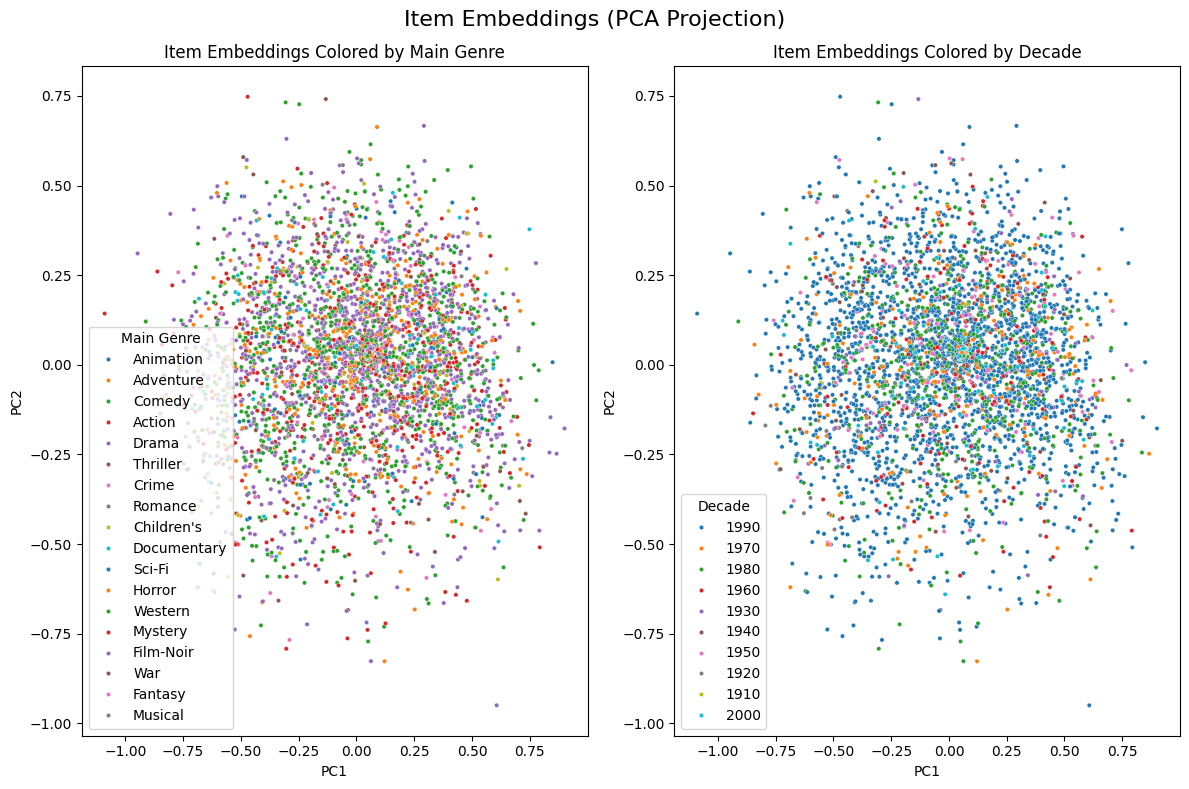

In [63]:
# latent factors
user_emb = best_model.A_     # shape (n_users, n_factors)
item_emb = best_model.B_     # shape (n_items, n_factors)

# example: item–item similarity matrix
item_sim = cosine_similarity(item_emb)

# example: user–user similarity matrix
user_sim = cosine_similarity(user_emb)

pca = PCA(n_components=2)
item_2d = pca.fit_transform(item_emb)

plt.figure(figsize=(12,8)).suptitle("Item Embeddings (PCA Projection)", fontsize=16)
plt.subplot(1, 2, 1)
sns.scatterplot(
    x=item_2d[:,0],
    y=item_2d[:,1],
    hue=movies['Main Genre'],
    palette='tab10',
    s=10,
    legend=True  # Show legend only if few categories
)
plt.title("Item Embeddings Colored by Main Genre")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.subplot(1, 2, 2)
sns.scatterplot(
    x=item_2d[:,0],
    y=item_2d[:,1],
    hue=movies['Decade'].astype(str),
    palette='tab10',
    s=10,
    legend=True   # Show legend only if few categories
)
plt.title("Item Embeddings Colored by Decade")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

##### Visualizing User Embeddings

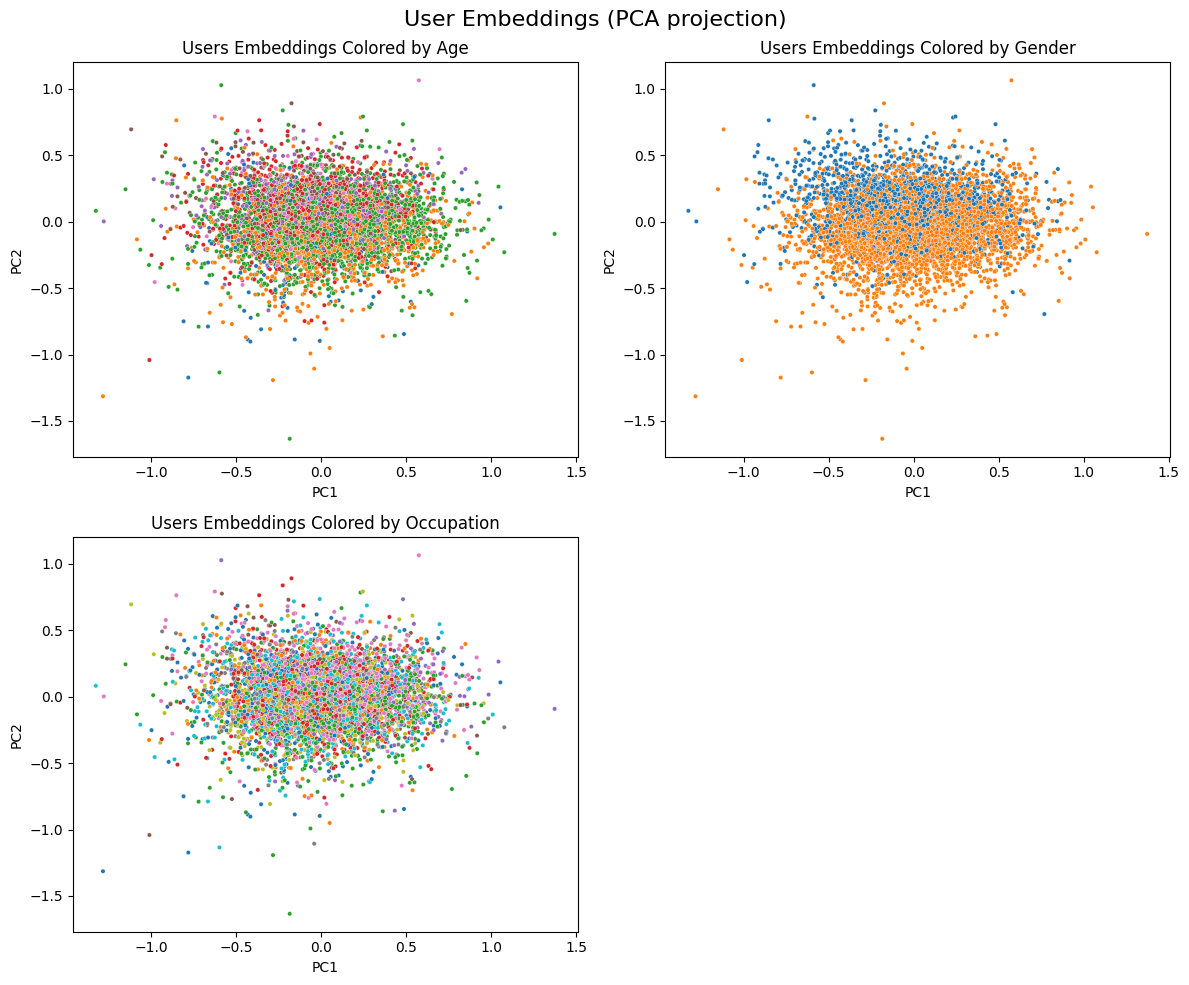

In [64]:
pca = PCA(n_components=2)
user_2d = pca.fit_transform(user_emb)

plt.figure(figsize=(12,10)).suptitle("User Embeddings (PCA projection)", fontsize=16)
plt.subplot(2,2,1)
sns.scatterplot(
    x=user_2d[:,0],
    y=user_2d[:,1],
    hue=users['Age'],  # or any categorical column
    palette='tab10',
    s=10,
    legend=False
)
plt.title("Users Embeddings Colored by Age")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.subplot(2,2,2)
sns.scatterplot(
    x=user_2d[:,0],
    y=user_2d[:,1],
    hue=users['Gender'],  # or any categorical column
    palette='tab10',
    s=10,
    legend=False
)
plt.title("Users Embeddings Colored by Gender")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.subplot(2,2,3)
sns.scatterplot(
    x=user_2d[:,0],
    y=user_2d[:,1],
    hue=users['Occupation'],  # or any categorical column
    palette='tab10',
    s=10,
    legend=False
)
plt.title("Users Embeddings Colored by Occupation") 
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

#### 3.5.2 UMAP

##### Visualizing Item Embeddings

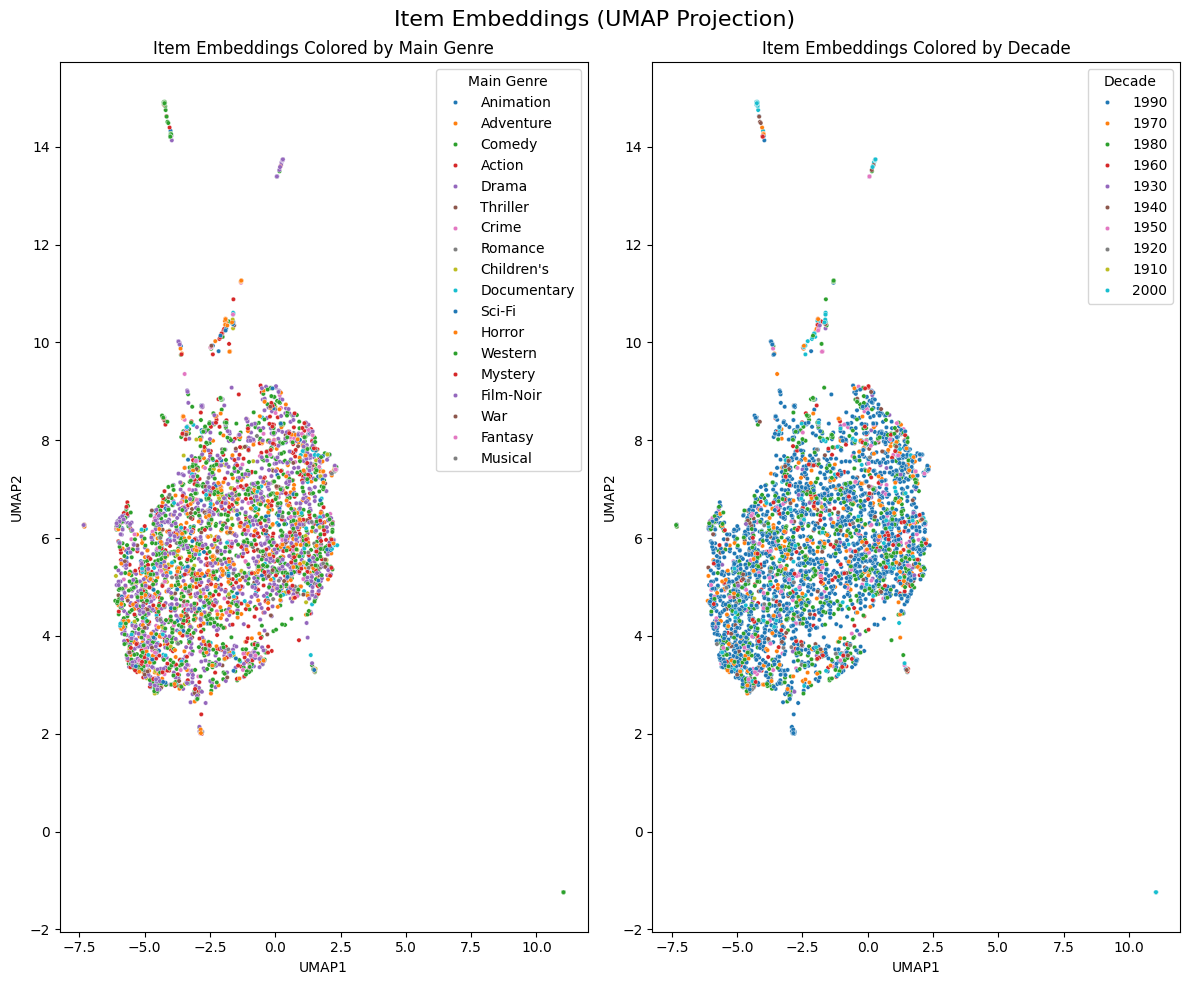

In [ ]:
# reduce item embeddings to 2D
reducer = umap.UMAP(n_components=2, 
                    random_state=42, 
                    n_neighbors=10, 
                    verbose=False)
item_2d = reducer.fit_transform(item_emb)


plt.figure(figsize=(12,10)).suptitle("Item Embeddings (UMAP Projection)", fontsize=16)
plt.subplot(1, 2, 1)
sns.scatterplot(
    x=item_2d[:,0],
    y=item_2d[:,1],
    hue=movies['Main Genre'],
    palette='tab10',
    s=10,
    legend=True  # Show legend only if few categories
)
plt.title("Item Embeddings Colored by Main Genre")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.subplot(1, 2, 2)
sns.scatterplot(
    x=item_2d[:,0],
    y=item_2d[:,1],
    hue=movies['Decade'].astype(str),
    palette='tab10',
    s=10,
    legend=True   # Show legend only if few categories
)
plt.title("Item Embeddings Colored by Decade")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.tight_layout()
plt.show()

##### Visualizing User Embeddings

UMAP(n_jobs=1, n_neighbors=50, random_state=42, verbose=True)
Fri Oct 31 12:58:26 2025 Construct fuzzy simplicial set
Fri Oct 31 12:58:26 2025 Finding Nearest Neighbors
Fri Oct 31 12:58:26 2025 Building RP forest with 9 trees
Fri Oct 31 12:58:31 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Fri Oct 31 12:58:41 2025 Finished Nearest Neighbor Search
Fri Oct 31 12:58:42 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Fri Oct 31 12:58:56 2025 Finished embedding


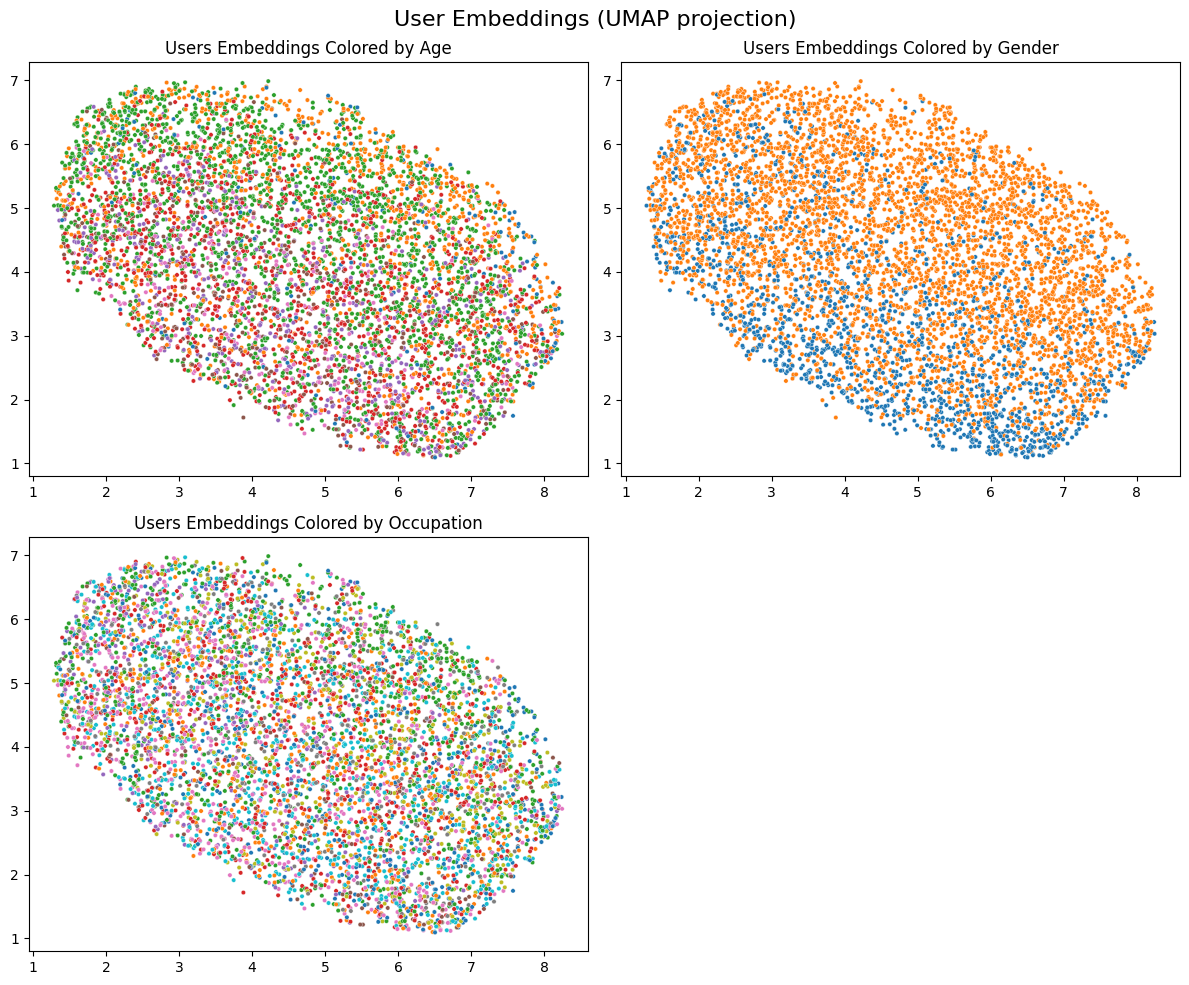

In [ ]:
# reduce user embeddings to 2D
reducer = umap.UMAP(n_components=2, 
                    random_state=42, 
                    n_neighbors=50, 
                    verbose=True)
user_2d = reducer.fit_transform(user_emb)

plt.figure(figsize=(12,10)).suptitle("User Embeddings (UMAP projection)", fontsize=16)
plt.subplot(2,2,1)
sns.scatterplot(
    x=user_2d[:,0],
    y=user_2d[:,1],
    hue=users['Age'],  # or any categorical column
    palette='tab10',
    s=10,
    legend=False
)
plt.title("Users Embeddings Colored by Age")
plt.subplot(2,2,2)
sns.scatterplot(
    x=user_2d[:,0],
    y=user_2d[:,1],
    hue=users['Gender'],  # or any categorical column
    palette='tab10',
    s=10,
    legend=False
)
plt.title("Users Embeddings Colored by Gender")
plt.subplot(2,2,3)
sns.scatterplot(
    x=user_2d[:,0],
    y=user_2d[:,1],
    hue=users['Occupation'],  # or any categorical column
    palette='tab10',
    s=10,
    legend=False
)
plt.title("Users Embeddings Colored by Occupation") 
plt.tight_layout()
plt.show()

## 4. Insights and Recommendations

- Users aged between **25 to 34** have watched and rated the most number of movies.
- Users who are **college/grad students** or who are at some **executive/managerial** position have watched and rated the most movies.
- **71.7%** of the users in our dataset who’ve rated the movies are Male.
- Most of the movies present in our dataset were released in the **90s** decade.
- The movie with the maximum no. of ratings is **American Beauty (1999)**.
- Top 3 movies similar to ‘Liar Liar’ on the item-based approach are **Mrs. Doubtfire (1993), Dumb & Dumber (1994)** and **Ace Ventura: Pet Detective (1994)**.
- On the basis of approach, Collaborative Filtering methods can be classified into **user-based** and **item-based** methods.
- Pearson Correlation ranges between **-1 to +1**, whereas Cosine Similarity belongs to the interval between **0 to 1**.
- From Matrix factorization (for the best model):
    Training RMSE = 0.8182
    Testing RMSE = 0.8691
    Training MAPE = 0.2537
    Testing MAPE = 0.2713
    - RMSE < 1 indicates small average prediction errors on a typical rating scale (usually 1–5).
    - The testing RMSE (0.8691) is close to the training RMSE (0.8182), showing low overfitting.
    - MAPE ≈ 0.25–0.27 means average prediction error is about 25–27%, which is acceptable for recommender systems.
    - In summary: the model generalizes well and performs at a solid accuracy level.

- <p>Given the following dense matrix:</p>
<pre>
[[1 0]
 [3 7]]
</pre>

<p>Compressed Sparse Row (CSR) representation is given as below:</p>
<pre><code>
shape  = (2, 2)

data   = [1, 3, 7]<!-- nonzero values in row-major order -->
indices= [0, 0, 1]<!-- column indices corresponding to each value in data -->
indptr = [0, 1, 3]<!-- row pointer: start index in data for each row, length = n_rows + 1 -->
</code></pre>

#### Strategies to refine the recommender system
<ul>
  <li>Collect more explicit feedback: ask for ratings, thumbs up/down, and short reviews to reduce reliance on implicit signals.</li>
  <li>Leverage implicit feedback: incorporate clicks, views, dwell time, purchases and session sequences as additional signals.</li>
  <li>Use temporal dynamics: include timestamps and time-decay to model changing user preferences.</li>
  <li>Incorporate side information: add user demographics, item metadata (category, tags), and context (device, location, time of day).</li>
  <li>Apply hybrid models: combine collaborative filtering with content-based methods to reduce cold-start problems.</li>
  <li>Try advanced matrix factorization variants: add biases, temporal factors, and regularization (SVD++, FunkSVD extensions).</li>
  <li>Experiment with factorization machines and LightFM: handle sparse features and mix of numeric/categorical side data efficiently.</li>
  <li>Explore neural models: autoencoders, neural collaborative filtering, and sequence models (RNN/Transformer) for session or sequence-aware recommendations.</li>
  <li>Use graph-based methods: build user-item interaction graphs and apply graph neural networks or PageRank-like propagation for richer relations.</li>
  <li>Optimize for business metrics: add objectives for diversity, novelty, serendipity, and revenue, not just RMSE/accuracy.</li>
  <li>Ensemble models: blend multiple models (CF, content, neural) to improve robustness and lift performance.</li>
  <li>Tune hyperparameters and regularization: run systematic searches and use validation curves to prevent overfitting.</li>
  <li>Improve evaluation: use holdout, time-split evaluation, precision/recall, NDCG, and online A/B tests to measure real impact.</li>
  <li>Address cold-start explicitly: use onboarding questionnaires, popularity priors, and content similarity for new users/items.</li>
  <li>Scale and latency engineering: use approximate nearest neighbors, model quantization, and caching for low-latency serving.</li>
  <li>Add explainability: provide short reasons or attributable signals to increase user trust and corrective feedback.</li>
  <li>Collect corrective feedback loops: let users mark “not relevant” and use that signal to retrain quickly.</li>
  <li>Monitor fairness and privacy: audit for bias, limit sensitive features, and apply differential privacy or federated learning if needed.</li>
  <li>Instrument and monitor production: track offline vs online drift, data quality, and model health metrics continuously.</li>
</ul>